In [4]:
# 0.1 = 10%
# 0.05 = 5%
# 0.01 = 1% 
# 0.005 = 0.5%
# 0.001 = 0.1%
# 0.0001 = 0.01%

# Focus on rare variants (AF ≤ 1e−3), -> 0.001 =0.1%  ; low freq 0.1 to 1 ; common 1% to infi 

# Normally it should like below based no classic studies like Goswami C, Chattopadhyay A, Chuang EY. Rare variants: data types and analysis strategies. Ann Transl Med. 2021 Jun;9(12):961. doi: 10.21037/atm-21-1635. PMID: 34277761; PMCID: PMC8267277.
# if float(variant) <= 0.001:
#                 ultra_rare_ee.append(float(variant))
#             elif float(variant) <= 0.01:
#                 rare_ee.append(float(variant))
#             elif float(variant) < 0.05:
#                 low_freq_ee.append(float(variant))
#             else:
#                 common_ee.append(float(variant))

### But by looking at the data and based on this paper Chen, W., Wang, S., Tithi, S.S. et al. A rare variant analysis framework using public genotype summary counts to prioritize disease-predisposition genes. Nat Commun 13, 2592 (2022). https://doi.org/10.1038/s41467-022-30248-0
#in paper they say "Focus on rare variants (AF ≤ 1e−3)", -> 0.001 =0.1%  and "relatively frequent variants, e.g., the AF range > [0.01, 0.1], "

### and https://discuss.gnomad.broadinstitute.org/t/rare-and-common-variants-numbers/332/2 
# # rare is <0.1% so 0.001 and common is >1% 0.01 ; # . We therefore made an adjustment to heterozygous genotypes with highly skewed allele balance (>0.9) at common variant sites (>0.01 AF)

ratio_syn_ee = []
syn_per_size_ee = []
af_ee = []

ultra_rare_ee = []
rare_ee = []
low_freq_ee = []
common_ee = []
with open('/mnt/project/exonhancer/ZENODO_REPO/gnomADv3_analysis/snps_analysis/hg38_EE_gnomAD_AF.tsv') as f:
    for line in f:
        ratio_syn_ee.append(float(line.strip().split()[3].replace(',', '.')))
        syn_per_size_ee.append(int(line.strip().split()[2])/int(line.strip().split()[1]))

        for variant in (line.strip().split()[4]).split(";"):
            af_ee.append(float(variant))
            if float(variant) <= 0.0001:
                ultra_rare_ee.append(float(variant))
            elif float(variant) <= 0.001:
                rare_ee.append(float(variant))
            elif float(variant) <= 0.01:
                low_freq_ee.append(float(variant))
            else:
                common_ee.append(float(variant))

ratio_syn_neg = []
syn_per_size_neg = []
af_neg = []

ultra_rare_neg = []
rare_neg = []
low_freq_neg = []
common_neg = []
with open('/mnt/project/exonhancer/ZENODO_REPO/gnomADv3_analysis/snps_analysis/hg38_ctrlNeg_gnomAD_AF.tsv') as f:
    for line in f:
        ratio_syn_neg.append(float(line.strip().split()[3].replace(',', '.')))
        syn_per_size_neg.append(int(line.strip().split()[2])/int(line.strip().split()[1]))

        try:
            for variant in (line.strip().split()[4]).split(";"):
                af_neg.append(float(variant))
                if float(variant) <= 0.0001:
                    ultra_rare_neg.append(float(variant))
                elif float(variant) <= 0.001:
                    rare_neg.append(float(variant))
                elif float(variant) <= 0.01:
                    low_freq_neg.append(float(variant))
                else:
                    common_neg.append(float(variant))
        except IndexError: #No variant in that region
            continue


In [5]:
# Compute medians
import numpy as np
from scipy.stats import shapiro, mannwhitneyu, ttest_ind

median1 = np.median(syn_per_size_ee)
median2 = np.median(syn_per_size_neg)

print(f"Median of list 1: {median1}")
print(f"Median of list 2: {median2}")

# Step 2: Check normality using Shapiro-Wilk test
shapiro1_stat, shapiro1_p = shapiro(syn_per_size_ee)
shapiro2_stat, shapiro2_p = shapiro(syn_per_size_neg)

print(f"Shapiro-Wilk test for list 1: p={shapiro1_p}")
print(f"Shapiro-Wilk test for list 2: p={shapiro2_p}")


# Step 3: Choose appropriate test
if shapiro1_p > 0.05 and shapiro2_p > 0.05:
    # Both distributions are normal — use t-test
    t_stat, t_p = ttest_ind(syn_per_size_ee, syn_per_size_neg, equal_var=False)
    print(f"T-test: t={t_stat}, p={t_p}")
else:
    # At least one distribution is not normal — use Mann-Whitney U
    u_stat, u_p = mannwhitneyu(syn_per_size_ee, syn_per_size_neg, alternative='two-sided')
    print(f"Mann-Whitney U test: U={u_stat}, p={u_p}")



Median of list 1: 0.0658682634730539
Median of list 2: 0.04216867469879518
Shapiro-Wilk test for list 1: p=0.0
Shapiro-Wilk test for list 2: p=0.0
Mann-Whitney U test: U=131936751.0, p=0.0


/home/mouren/.local/lib/python3.8/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


cEEs v.s. Ctrl-: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=0.000e+00 U_stat=1.170e+08


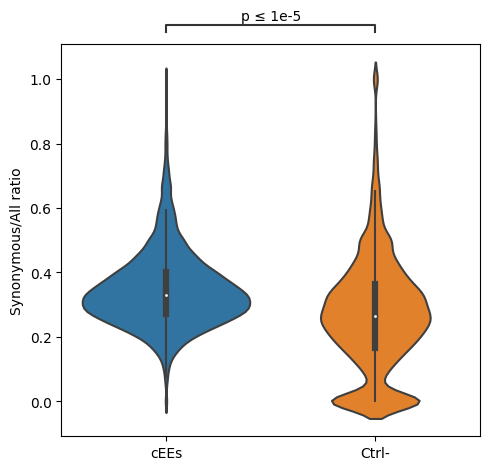

In [7]:
### Plot AF distribution 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from statannot import add_stat_annotation
matplotlib.rcParams['pdf.fonttype'] = 42

# Create a DataFrame suitable for seaborn
df = pd.DataFrame({'Synonymous/All ratio': ratio_syn_ee + ratio_syn_neg,'Dataset': ['cEEs'] * len(ratio_syn_ee) + ['Ctrl-'] * len(ratio_syn_neg)})

# Plot
plt.figure(figsize=(5, 5))
ax = sns.violinplot(x='Dataset', y='Synonymous/All ratio', data=df, inner='box') #,scale='width', cut=0)

# Add statistical annotation
add_stat_annotation(ax, data=df, x='Dataset', y='Synonymous/All ratio',
                    box_pairs=[("cEEs", "Ctrl-")],
                    test='Mann-Whitney', text_format='simple', loc='outside', verbose=1)

plt.tight_layout()
plt.xlabel(None)

plt.savefig("/home/mouren/Images/revisions/rev_1_pt7_syn_ratio.pdf", format="pdf", bbox_inches="tight", dpi=450)
plt.savefig("/home/mouren/Images/revisions/rev_1_pt7_syn_ratio.png", format="png", bbox_inches="tight", dpi=450)

plt.show()

In [38]:
#### PT 13
print("u rare ee perc", (len(ultra_rare_ee)*100)/len(af_ee))
print("rare ee perc", (len(rare_ee)*100)/len(af_ee))
print("low ee perc", (len(low_freq_ee)*100)/len(af_ee))
print("common ee perc", (len(common_ee)*100)/len(af_ee))

print("u rare neg perc", (len(ultra_rare_neg)*100)/len(af_neg))
print("rare neg perc", (len(rare_neg)*100)/len(af_neg))
print("low neg perc", (len(low_freq_neg)*100)/len(af_neg))
print("common neg perc", (len(common_neg)*100)/len(af_neg))

from statsmodels.stats.proportion import proportions_ztest
nobs = [len(af_ee), len(af_neg)]

count = [len(ultra_rare_ee), len(ultra_rare_neg)]
stat, pval = proportions_ztest(count, nobs)
print(f"Z-test p-value: {pval}")

count = [len(rare_ee), len(rare_neg)]
stat, pval = proportions_ztest(count, nobs)
print(f"Z-test p-value: {pval}")

count = [len(low_freq_ee), len(low_freq_neg)]
stat, pval = proportions_ztest(count, nobs)
print(f"Z-test p-value: {pval}")

count = [len(common_ee), len(common_neg)]
stat, pval = proportions_ztest(count, nobs)
print(f"Z-test p-value: {pval}")


u rare ee perc 90.93811448515697
rare ee perc 6.000535546619563
low ee perc 1.8793549076641778
common ee perc 1.18199506055929
u rare neg perc 90.44530161700759
rare neg perc 6.044195666809215
low neg perc 2.06201281242458
common neg perc 1.4484899037586216
Z-test p-value: 1.8297037990238066e-13
Z-test p-value: 0.4285094588517807
Z-test p-value: 9.510286883541054e-09
Z-test p-value: 2.940429238810304e-25
